In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os 
import sys
import gc 
import plotly.express as px
import pandas as pd
import numpy as np 
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


import matplotlib.pyplot as plt
from mnist_cvae import CVAE



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


INPUT_DIM = 28 * 28     # size of each input
HIDDEN_DIM = 784        # hidden dimension
LATENT_DIM = [40,50,60,70,80,100,128,140,160,200,220,250] # latent dims
N_CLASSES = 10          # number of classes in the data
RANGE = 1.5             # Max values in latent_vector 
HIDDEN_DIMS = [128, 64]

In [2]:
cvae_40 = CVAE(INPUT_DIM,HIDDEN_DIM,LATENT_DIM[0],N_CLASSES)
cvae_40.load_state_dict(torch.load("mnist_cvae/cvae_40.pt"))
cvae_40.eval()

cvae_50 = CVAE(INPUT_DIM,HIDDEN_DIM,LATENT_DIM[1],N_CLASSES)
cvae_50.load_state_dict(torch.load("mnist_cvae/cvae_50.pt"))
cvae_50.eval()

cvae_60 = CVAE(INPUT_DIM,HIDDEN_DIM,LATENT_DIM[2],N_CLASSES)
cvae_60.load_state_dict(torch.load("mnist_cvae/cvae_60.pt"))
cvae_60.eval()

cvae_70 = CVAE(INPUT_DIM,HIDDEN_DIM,LATENT_DIM[3],N_CLASSES)
cvae_70.load_state_dict(torch.load("mnist_cvae/cvae_70.pt"))
cvae_70.eval()

cvae_80 = CVAE(INPUT_DIM,HIDDEN_DIM,LATENT_DIM[4],N_CLASSES)
cvae_80.load_state_dict(torch.load("mnist_cvae/cvae_80.pt"))
cvae_80.eval()

cvae_100 = CVAE(INPUT_DIM,HIDDEN_DIM,LATENT_DIM[5],N_CLASSES)
cvae_100.load_state_dict(torch.load("mnist_cvae/cvae_100.pt"))
cvae_100.eval()

cvae_128 = CVAE(INPUT_DIM,HIDDEN_DIM,LATENT_DIM[6],N_CLASSES)
cvae_128.load_state_dict(torch.load("mnist_cvae/cvae_128.pt"))
cvae_128.eval()

cvae_140 = CVAE(INPUT_DIM,HIDDEN_DIM,LATENT_DIM[7],N_CLASSES)
cvae_140.load_state_dict(torch.load("mnist_cvae/cvae_140.pt"))
cvae_140.eval()

cvae_160 = CVAE(INPUT_DIM,HIDDEN_DIM,LATENT_DIM[8],N_CLASSES)
cvae_160.load_state_dict(torch.load("mnist_cvae/cvae_160.pt"))
cvae_160.eval()

cvae_200 = CVAE(INPUT_DIM,HIDDEN_DIM,LATENT_DIM[9],N_CLASSES)
cvae_200.load_state_dict(torch.load("mnist_cvae/cvae_200.pt"))
cvae_200.eval()

cvae_220 = CVAE(INPUT_DIM,HIDDEN_DIM,LATENT_DIM[10],N_CLASSES)
cvae_220.load_state_dict(torch.load("mnist_cvae/cvae_220.pt"))
cvae_220.eval()

cvae_250 = CVAE(INPUT_DIM,HIDDEN_DIM,LATENT_DIM[11],N_CLASSES)
cvae_250.load_state_dict(torch.load("mnist_cvae/cvae_250.pt"))
cvae_250.eval()

models = [cvae_40,cvae_50,cvae_60,cvae_70,cvae_80,cvae_100,cvae_128,cvae_140,cvae_160,cvae_200,cvae_220,cvae_250]

classifier = nn.Sequential(nn.Linear(INPUT_DIM, HIDDEN_DIMS[0]),
                      nn.ReLU(),
                      nn.Linear(HIDDEN_DIMS[0], HIDDEN_DIMS[1]),
                      nn.ReLU(),
                      nn.Linear(HIDDEN_DIMS[1], N_CLASSES),
                      nn.LogSoftmax(dim=1))
classifier.load_state_dict(torch.load("mnist_classif/mnist_classif.pt"))
classifier.eval()

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)

In [3]:
#Functions 
def idx2onehot(idx, n=N_CLASSES):

    assert idx.shape[1] == 1
    assert torch.max(idx).item() < n

    onehot = torch.zeros(idx.size(0), n)
    onehot.scatter_(1, idx.data, 1)

    return onehot
def latent_vector(c1=0,c2=0,dim=LATENT_DIM[0],ax1=0,ax2=1):
    z = torch.zeros(1, dim)
    z[0][ax1]= c1
    z[0][ax2]= c2

    return z 

def onehotmixer(a=0,b=0,mix=False):
    y = torch.zeros(1, 1).to(dtype=torch.long)
    y = idx2onehot(y)
    y[0][0] = 0
    y[0][a] = 1
    if mix : 
        y[0][b] = 1

    return y

def list_print(list1,list2=[]) : 
    average = np.mean(list1)
    if len(list2)>0 : 
        for i in range(len(list1)):
            sys.stdout.write("pred : "+str(list2[i])+" : "+"{:.2f}".format(list1[i])+ " | ")
    else :
        for data in list1:
            sys.stdout.write("{:.2f}".format(data)+ " | ")
        sys.stdout.write(" av = "+"{:.2f}".format(average))
        
def class_proba(c_model,img):
    with torch.no_grad():
        logps = c_model(img.view(1,INPUT_DIM))        
    ps = torch.exp(logps)
    probab = list(ps.numpy()[0])
    return probab

def classify(img,second=False): 
    probab = class_proba(classifier,img)
    pred_label = probab.index(max(probab))
    maximum = max(probab)
    if second : 
        probab.remove(max(probab))
        return pred_label, maximum ,probab.index(max(probab)), max(probab)
    else :
        return pred_label, maximum 


In [4]:
def representant(number,model=models[9],latent_dim=LATENT_DIM[9],rand=True):
    if rand :
        z = torch.randn((1,latent_dim))/4
    else :
        z = torch.zeros((1,latent_dim))
    y = onehotmixer(number)
    z = torch.cat((z, y), dim=1)
    with torch.no_grad():
        reconstructed_img = model.decoder(z)   
    img = reconstructed_img.view(28, 28).data 

    return img

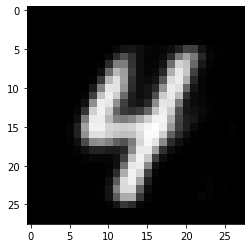

In [17]:
plt.imshow(representant(4,models[9],LATENT_DIM[9],rand=True), cmap = plt.cm.gray)
plt.show()

In [6]:
def enc_dec(img,Cp,model):
    img = img.view(-1, 28 * 28)
    Cp = onehotmixer(Cp)
    x = torch.cat((img, Cp), dim=1)

    # encode
    with torch.no_grad():
        z_mu, z_var = model.encoder(x)

    # sample from the distribution having latent parameters z_mu, z_var
    # reparameterize
    std = torch.exp(z_var / 2)
    eps = torch.randn_like(std)
    x_sample = eps.mul(std).add_(z_mu)

    z = torch.cat((x_sample, Cp), dim=1)

    # decode
    with torch.no_grad():
        generated_x = model.decoder(z)

    img = generated_x.view(28, 28).data

    return img

In [7]:
def compute_KLD(img,label,model):
    x = img.view(-1, 28 * 28)
    # convert y into one-hot encoding
    y = onehotmixer(label)
    x = torch.cat((x, y), dim=1)
    # encode
    with torch.no_grad():
        z_mu, z_var = model.encoder(x)
        
    return -0.5 * torch.sum(1 + z_var - z_mu.pow(2) - z_var.exp())

In [8]:
def rescale(arr):
    arr = (arr-np.min(arr))/(np.max(arr)-np.min(arr))
    return arr
    

Our goal is to identify a metric to evaluate how good a counterfactual is. 

We would like our counterfactuals x' to meet the below requirements : 

- The difference between x and x' should be sparse
- x' should lie in the dataset distribution 
- x' should be as close as possible to x 

We have identified the KL divergece, Binary Cross entropy and the ouput of a classifier as potential members of our classifier. We would like to know which are more relevant to our goal.

Now that we have all our counterfactuals, we are going to classify them according to
different metrics based on the array 'values' and see which look the best. 

In [9]:
def spider(vals):
    df = pd.DataFrame(dict(r=vals,theta=['RCL Cp','KLD Cp','BCE','RCL C','KLD C']))
    fig = px.line_polar(df, r='r', theta='theta', line_close=True)
    fig.update_traces(fill='toself')
    fig.show()

In [10]:
def compute_values(x_ctf,x,number,C,m=9):
    RCL1 = F.binary_cross_entropy(x_ctf, enc_dec(x_ctf,C,models[m]),
                                                 reduction='sum')
    RCL2 = F.binary_cross_entropy(x_ctf, enc_dec(x_ctf,number,models[m]),
                                 reduction='sum')
    BCE = F.binary_cross_entropy(x_ctf, x, reduction='sum')
    KLD1 = compute_KLD(x,C,models[m])
    KLD2 = compute_KLD(x,number,models[m])
    
    return RCL1, RCL2, BCE, KLD1, KLD2 

In [11]:
def compute_ctfs(number, size,Cs = range(N_CLASSES)):
    ctfs = []
    values = []
    count = 0
    for i in range(size): 
        for m in range(len(models)):
            for C in Cs:
                # Generate ctf with conditional number 
                x = representant(C,models[m],LATENT_DIM[m],rand=True)
                x_ctf = enc_dec(x,number,models[m])
                
                pred1, P1, pred2, P2 = classify(x_ctf,second=True)
                if(pred1==C and pred2==number) :
                    #Compute values 
                    RCL1, RCL2, BCE, KLD1, KLD2 = compute_values(x_ctf,x,number,C,m)

                    #Fill arrays 
                    ctfs.append(x_ctf)
                    values.append([RCL1,RCL2,BCE,KLD1,KLD2,P1,P2])
                    count+=1
    #Scaling 
    values = np.array(values)
    for i in range(5): 
        values[:,i] = rescale(values[:,i])
        
    return ctfs, values 

In [12]:
def plot_img_bar(imgs,vals,n=1):
    for k in 5*np.arange(n):
        fig = plt.figure(figsize=(13, 8))
        ax = []
        for i in range(5):
            ax.append(fig.add_subplot(1, 5, i + 1))
            plt.imshow(imgs[k+i],cmap = plt.cm.gray)

        plt.show()  # finally, render the plot

        X = np.arange(7)
        plt.bar(X ,vals[k+0])
        plt.bar(X +8, vals[k+1])
        plt.bar(X +16, vals[k+2])
        plt.bar(X +24, vals[k+3])
        plt.bar(X +32, vals[k+4])
        plt.ylim(0,1)
        plt.tight_layout()

        plt.show()

In [15]:
number = 4
img, val = compute_ctfs(number,100)

4


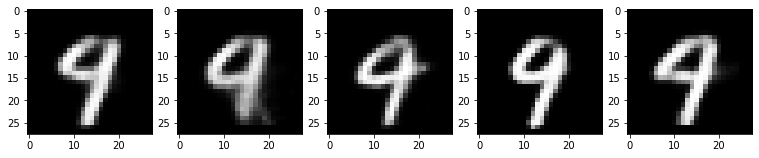

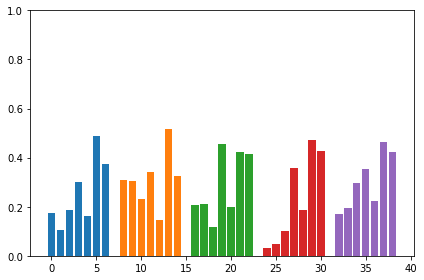

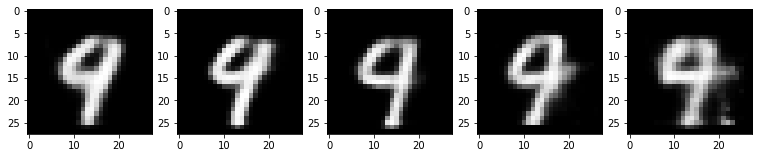

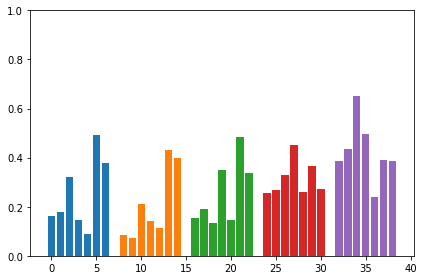

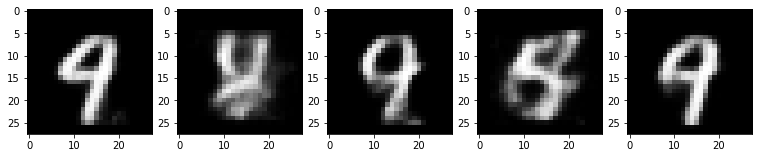

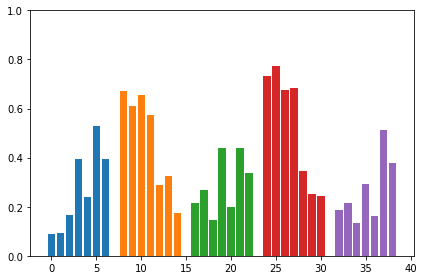

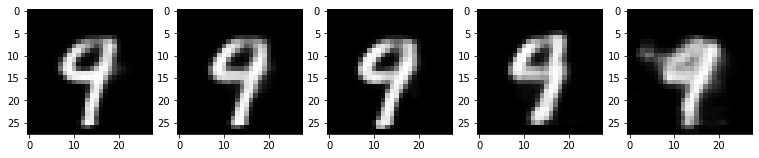

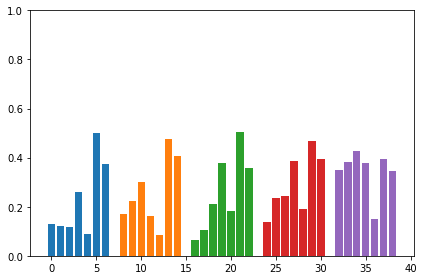

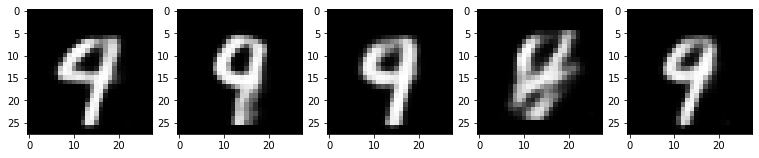

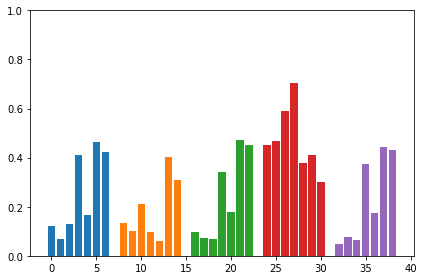

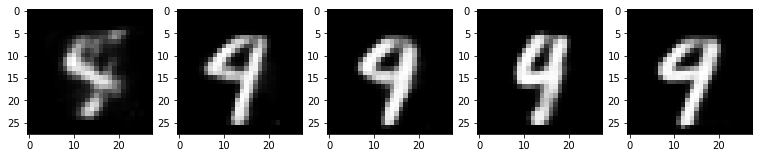

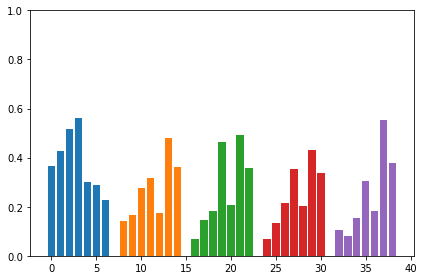

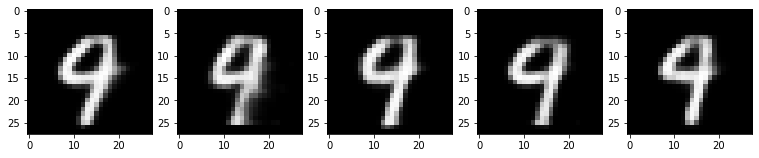

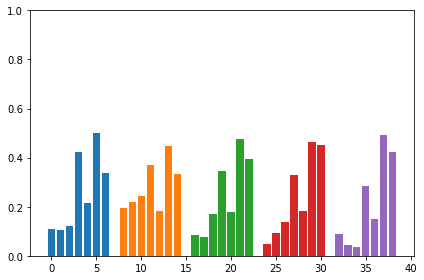

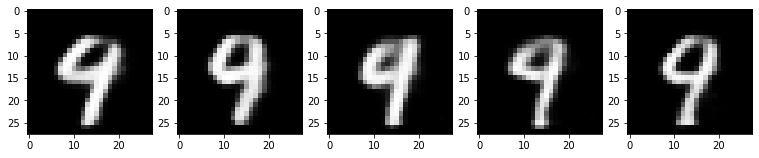

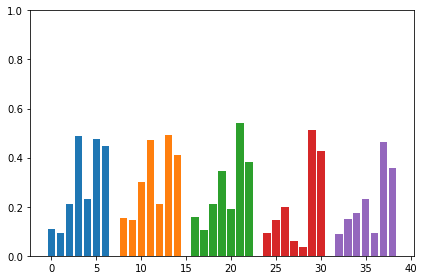

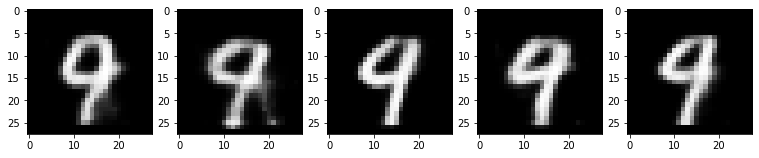

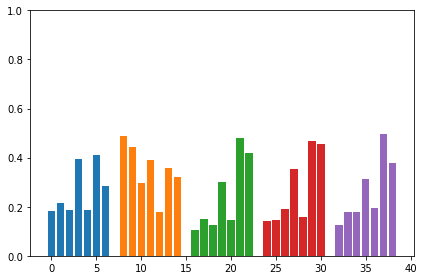

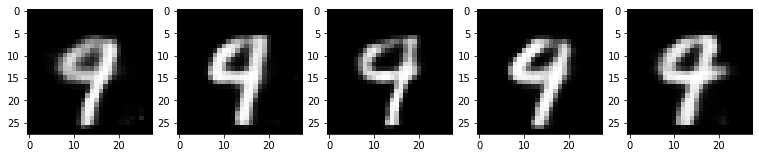

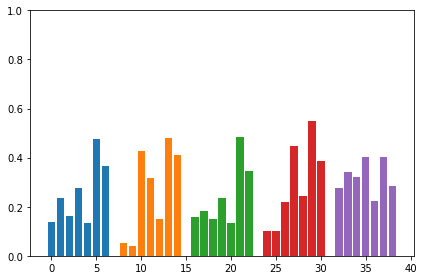

In [16]:
print(number)
ref = [compute_values(representant(number),representant(number),number,number) for i in range(1000)]
#Scaling 
ref = np.array(ref)
for i in range(5): 
    ref[:,i] = rescale(ref[:,i])
ref = np.mean(ref,axis=0)
ref = np.zeros(5)

val_m = (val[:,0]-val[:,1])**2 + (val[:,3]-2*val[:,4])**2 + 0.5*(val[:,5]-1.2*val[:,6])**2
+((val[:,0]-ref[0])**2 + (val[:,1]-ref[1])**2 
    + 0.5*(val[:,2]-ref[2])**2  
    + (val[:,3]-ref[3])**2 + (val[:,4]-ref[4])**2)
- (val[:,5] + val[:,6])
indices = np.argpartition(val_m, 100)[:100]
best_im = [img[i] for i in indices]
best_val = [val[i] for i in indices]

plot_img_bar(best_im,best_val,10)